In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pympc.models.boxatlas_parametric import BoxAtlas, MovingLimb, FixedLimb
from pympc.dynamical_systems import dare, moas_closed_loop_from_orthogonal_domains
from pympc.control import MPCHybridController
import pympc.plot as mpc_plt

Numeric parameters

In [3]:
parameters = {
    'mass': 1.,
    'stiffness': 100.,
    'damping': 1000.,
    'friction_coefficient': .5,
    'gravity': 10.,
    'sampling_time': .1
    }

Nominal state and input

In [4]:
weight = parameters['mass'] * parameters['gravity']
penetration = weight / parameters['stiffness']
nominal_limb_positions = {
    'lf': np.array([[.2], [-.5 - penetration / 2.]]),
    'rf': np.array([[-.2], [-.5 - penetration / 2.]]),
    'lh': np.array([[.3], [.1]]),
    'rh': np.array([[-.3], [.1]])
    }
nominal_limb_forces = {
    'lf': np.array([[weight / 2.], [0.]]),
    'rf': np.array([[weight / 2.], [0.]]),
    'lh': np.zeros((2,1)),
    'rh': np.zeros((2,1))
    }

State limits

In [5]:
kinematic_limits = {
        'lf': {'min': np.array([[.0],[-.7]]), 'max': np.array([[.4],[-.3]])},
        'rf': {'min': np.array([[-.4],[-.7]]), 'max': np.array([[0.],[-.3]])},
        'lh': {'min': np.array([[.2],[-.1]]), 'max': np.array([[.6],[.3]])},
        'rh': {'min': np.array([[-.6],[-.1]]), 'max': np.array([[-.2],[.3]])},
        }
velocity_limits = {
        'lf': {'min': -np.ones((2,1)), 'max': np.ones((2,1))},
        'rf': {'min': -np.ones((2,1)), 'max': np.ones((2,1))},
        'lh': {'min': -np.ones((2,1)), 'max': np.ones((2,1))},
        'rh': {'min': -np.ones((2,1)), 'max': np.ones((2,1))},
        }

Force limits

In [6]:
f_n_max = 2. * weight
f_t_max = parameters['friction_coefficient'] * f_n_max
f_min = np.array([[0.], [-f_t_max]])
f_max = np.array([[f_n_max], [f_t_max]])
force_limits = {
        'lf': {'min': f_min, 'max': f_max},
        'rf': {'min': f_min, 'max': f_max},
        'lh': {'min': f_min, 'max': f_max},
        'rh': {'min': f_min, 'max': f_max},
        }

Robot topology

In [7]:
lh = [
    MovingLimb(np.array([[1., 0.],[0., -1.]]), np.ones((2,1))/2., None),
    MovingLimb(-np.eye(2), np.array([[-.5],[.5]]), 0)
    ]
rh = [
    MovingLimb(-np.eye(2), np.ones((2,1))/2., None),
    MovingLimb(np.array([[1., 0.],[0., -1.]]), np.array([[-.5],[.5]]), 0)
    ]
lf = FixedLimb(np.array([[.2],[-.5]]), np.array([[0.],[1.]]))
rf = FixedLimb(np.array([[-.2],[-.5]]), np.array([[0.],[1.]]))
topology = {
    'moving': {'lh': lh, 'rh': rh},
    'fixed': {'lf': lf, 'rf': rf},
    }

Construct box atlas

In [11]:
box_atlas = BoxAtlas(
    topology,
    parameters,
    nominal_limb_positions,
    nominal_limb_forces,
    kinematic_limits,
    velocity_limits,
    force_limits
)

Hybrid controller ingredients

In [12]:
N = 10
Q = np.eye(box_atlas.n_x)
R = np.eye(box_atlas.n_u)
objective_norm = 'two'
terminal_mode = 0
P, K = dare(
    box_atlas.affine_systems[terminal_mode].A,
    box_atlas.affine_systems[terminal_mode].B,
    Q,
    R)
X_N = moas_closed_loop_from_orthogonal_domains(
    box_atlas.affine_systems[terminal_mode].A,
    box_atlas.affine_systems[terminal_mode].B,
    K,
    box_atlas.state_domains[terminal_mode],
    box_atlas.input_domains[terminal_mode])

Computation of MOAS started... MOAS found.
MOAS facets are 270, removing redundant ones... redundant factes removed, MOAS facets are 124.


Hybrid controller

In [13]:
controller = MPCHybridController(box_atlas.pwa_system, N, objective_norm, Q, R, P, X_N)

Closed-loop system simulation

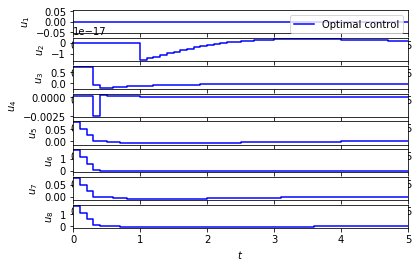

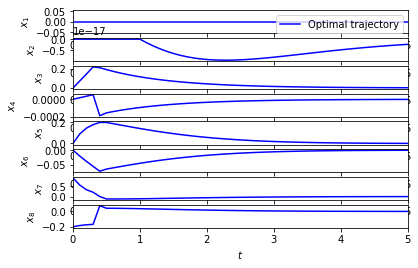

In [19]:
N_sim = 50
x_0 = np.zeros((8,1))
x_0[6,0] = .9 # v_b_x
x_0[7,0] = -.2 # v_b_y
u = []
x = [x_0]
u_ws = None
x_ws = None
ss_ws = None
for k in range(N_sim):
    u_k, x_k, ss_k = controller.feedforward(x[k], u_ws, x_ws, ss_ws)[0:3]
    print('Time step ' + str(k) + ': ' + str(ss_k) + '.\r'),
    x_next = box_atlas.pwa_system.simulate(x[k], [u_k[0]])[0][1]
    u.append(u_k[0])
    x.append(x_next)
    u_ws = u_k[1:] + [K.dot(x_k[-1])]
    x_ws = x_k[1:] + [box_atlas.pwa_system.simulate(x_k[-1], [u_ws[-1]])[0][1]]
    ss_ws = ss_k[1:] + (terminal_mode,)
mpc_plt.input_sequence(u, parameters['sampling_time'])
plt.show()
mpc_plt.state_trajectory(x, parameters['sampling_time'])
plt.show()